In [1]:
# import comet_ml in the top of your file
from comet_ml import Experiment
    
# Add the following code anywhere in your machine learning file
experiment = Experiment(api_key="eg5dt1OjVmw0QQTkYFQW8DdNc",
                        project_name="celeba-autoencoder", workspace="christianschneeweiss")

COMET INFO: old comet version (2.0.1) detected. current: 2.0.2 please update your comet lib with command: `pip install --no-cache-dir --upgrade comet_ml`
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/christianschneeweiss/celeba-autoencoder/5b41400a408748ae9fa1156b4ea0d614



In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras.layers as layers
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import Sequence
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.backend import set_session

In [3]:
PATH = "data/"
#config = tf.ConfigProto()
#config.gpu_options.per_process_gpu_memory_fraction = 0.5
#session = tf.Session(config=config)
#set_session(session)

In [4]:
generator = ImageDataGenerator(rescale=1./255., validation_split=0.3)

In [5]:
train_generator = generator.flow_from_directory(PATH,target_size=(64,64),color_mode="rgb",batch_size=128, subset="training")
val_generator = generator.flow_from_directory(PATH,target_size=(64,64),color_mode="rgb",batch_size=128, subset="validation")

Found 141820 images belonging to 2 classes.
Found 60779 images belonging to 2 classes.


In [6]:
encoder_input = layers.Input(shape=(64,64,3), name="original_image")
x = layers.Conv2D(16,(3,3),activation="relu")(encoder_input)
x = layers.Conv2D(32,(3,3),activation="relu")(x)
x = layers.MaxPooling2D()(x)
x = layers.Conv2D(16,(3,3),activation="relu")(x)
x = layers.Conv2D(32,(3,3),activation="relu")(x)
x = layers.MaxPooling2D()(x)
x = layers.Conv2D(32,(3,3),activation="relu")(x)
x = layers.Conv2D(64,(5,5),activation="relu", padding="same")(x)
x = layers.Conv2D(128,(5,5),activation="relu", padding="valid")(x)
x = layers.Conv2D(128,(5,5),activation="relu", padding="valid")(x)
encoded_img = layers.Flatten(name="Encoded_image")(x)
encoder = Model(inputs=encoder_input, outputs=encoded_img, name="Encoder")
encoder.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
original_image (InputLayer)  (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 62, 62, 16)        448       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 60, 60, 32)        4640      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 16)        4624      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 26, 26, 32)        4640      
_________________________________________________________________
max_

In [7]:
decoder_input = layers.Input(shape=(1152,),name="encoded_image")
x = layers.Reshape((3,3,128))(decoder_input)
x = layers.Conv2DTranspose(128,(5,5),activation="relu", padding="valid")(x)
x = layers.Conv2DTranspose(128,(5,5),activation="relu", padding="valid")(x)
x = layers.Conv2DTranspose(64,(5,5),activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(32,(3,3),activation="relu")(x)
x = layers.UpSampling2D()(x)
x = layers.Conv2DTranspose(32,(3,3),activation="relu")(x)
x = layers.Conv2DTranspose(16,(3,3),activation="relu")(x)
x = layers.UpSampling2D()(x)
x = layers.Conv2DTranspose(32,(3,3),activation="relu")(x)
decoded_img = layers.Conv2DTranspose(3,(3,3),activation="relu", name="decoded_img")(x)
decoder = Model(inputs=decoder_input, outputs=decoded_img, name="Decoder")
decoder.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoded_image (InputLayer)   (None, 1152)              0         
_________________________________________________________________
reshape (Reshape)            (None, 3, 3, 128)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 7, 7, 128)         409728    
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 11, 11, 128)       409728    
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 11, 11, 64)        204864    
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 13, 13, 32)        18464     
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 26, 26, 32)        0         
__________

In [8]:
autoencoder_input = layers.Input(shape=(64,64,3), name="original_image")
x = encoder(autoencoder_input)
decoded_img = decoder(x)

autoencoder = Model(inputs=autoencoder_input, outputs=decoded_img, name="Autoencoder")
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
original_image (InputLayer)  (None, 64, 64, 3)         0         
_________________________________________________________________
Encoder (Model)              (None, 1152)              689520    
_________________________________________________________________
Decoder (Model)              (None, 64, 64, 3)         1062163   
Total params: 1,751,683
Trainable params: 1,751,683
Non-trainable params: 0
_________________________________________________________________


In [9]:
autoencoder.compile(loss="binary_crossentropy",optimizer="adam")

In [10]:
class DataGenerator(Sequence):
    'Generates data for Keras'
    def __init__(self, generator):
        'Initialization'
        self.batch_size = generator.batch_size
        self.on_epoch_end()
        self.generator = generator

    def __len__(self):
        'Denotes the number of batches per epoch'
        return self.generator.samples//self.generator.batch_size

    def __getitem__(self, index):
        batch = next(self.generator)

        return batch[:][0], batch[:][0]

    def on_epoch_end(self):
        pass

In [11]:
val_gen = DataGenerator(val_generator)
train_gen = DataGenerator(train_generator)

early_stopping = EarlyStopping(patience=3,verbose=1,restore_best_weights=True)
with experiment.train():
    autoencoder.fit_generator(train_gen,
                              epochs=50, 
                              validation_data=val_gen)

Instructions for updating:
Use tf.cast instead.


Using TensorFlow backend.


Epoch 1/50
1107/1107 [==============================] - 390s 352ms/step - loss: 79.1255 - val_loss: 70.2815
Epoch 2/50
1107/1107 [==============================] - 385s 348ms/step - loss: 70.0367 - val_loss: 71.4200
Epoch 3/50
1107/1107 [==============================] - 385s 348ms/step - loss: 68.7907 - val_loss: 67.4409
Epoch 4/50
1107/1107 [==============================] - 386s 349ms/step - loss: 67.3316 - val_loss: 66.4992
Epoch 5/50
1107/1107 [==============================] - 385s 348ms/step - loss: 66.6520 - val_loss: 65.9598
Epoch 6/50
1107/1107 [==============================] - 385s 348ms/step - loss: 66.5532 - val_loss: 67.3117
Epoch 7/50
1107/1107 [==============================] - 386s 348ms/step - loss: 66.2951 - val_loss: 65.6555
Epoch 8/50
1107/1107 [==============================] - 386s 349ms/step - loss: 66.1679 - val_loss: 65.5662
Epoch 9/50
1107/1107 [==============================] - 386s 349ms/step - loss: 65.5517 - val_loss: 65.3975
Epoch 10/50
1107/1107 [=====

Epoch 46/50
1107/1107 [==============================] - 386s 348ms/step - loss: 64.2927 - val_loss: 64.3388
Epoch 47/50
1107/1107 [==============================] - 385s 348ms/step - loss: 63.9179 - val_loss: 63.5548
Epoch 48/50
1107/1107 [==============================] - 387s 349ms/step - loss: 64.3489 - val_loss: 63.8611
Epoch 49/50
1107/1107 [==============================] - 387s 349ms/step - loss: 63.8243 - val_loss: 63.5356
Epoch 50/50
1107/1107 [==============================] - 385s 348ms/step - loss: 63.8924 - val_loss: 63.4857


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


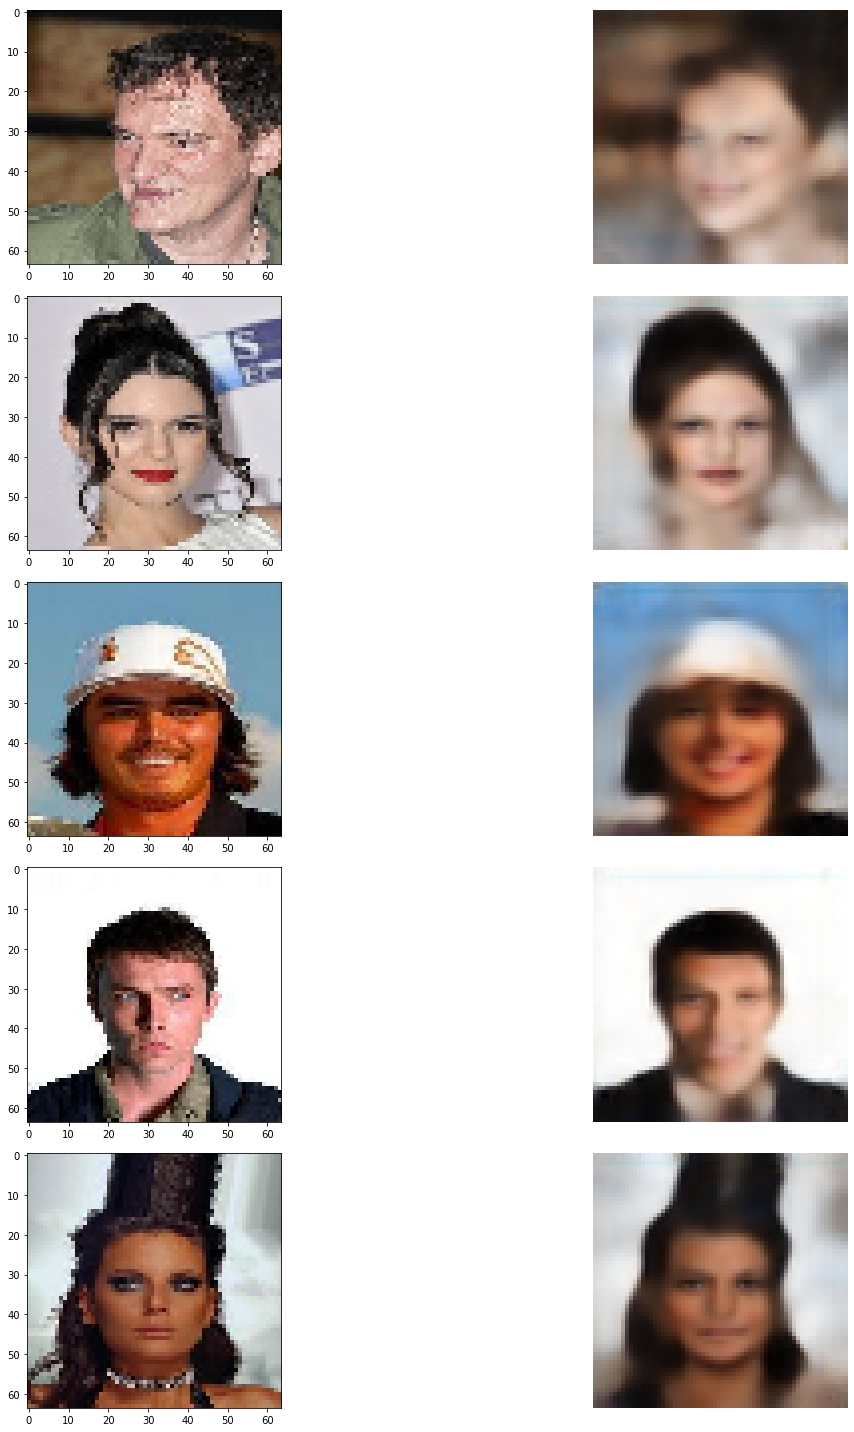

In [13]:
def plot_images(autoencoder, image_gen,figsize=(20,20),rows=5):
    x, y = val_gen.__getitem__(5)
    y[0].shape
    preds = autoencoder.predict(x)
    
    plt.figure(figsize=figsize)

    i=1
    while i < rows*2:
        rand_index = np.random.randint(len(y))
        plt.subplot(rows,2,i)
        plt.imshow(y[rand_index])
        plt.subplot(rows,2,i+1)
        plt.imshow(preds[rand_index])
        plt.axis('off')
        i+=2

    plt.tight_layout()
    
plot_images(autoencoder=autoencoder, image_gen=val_gen)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

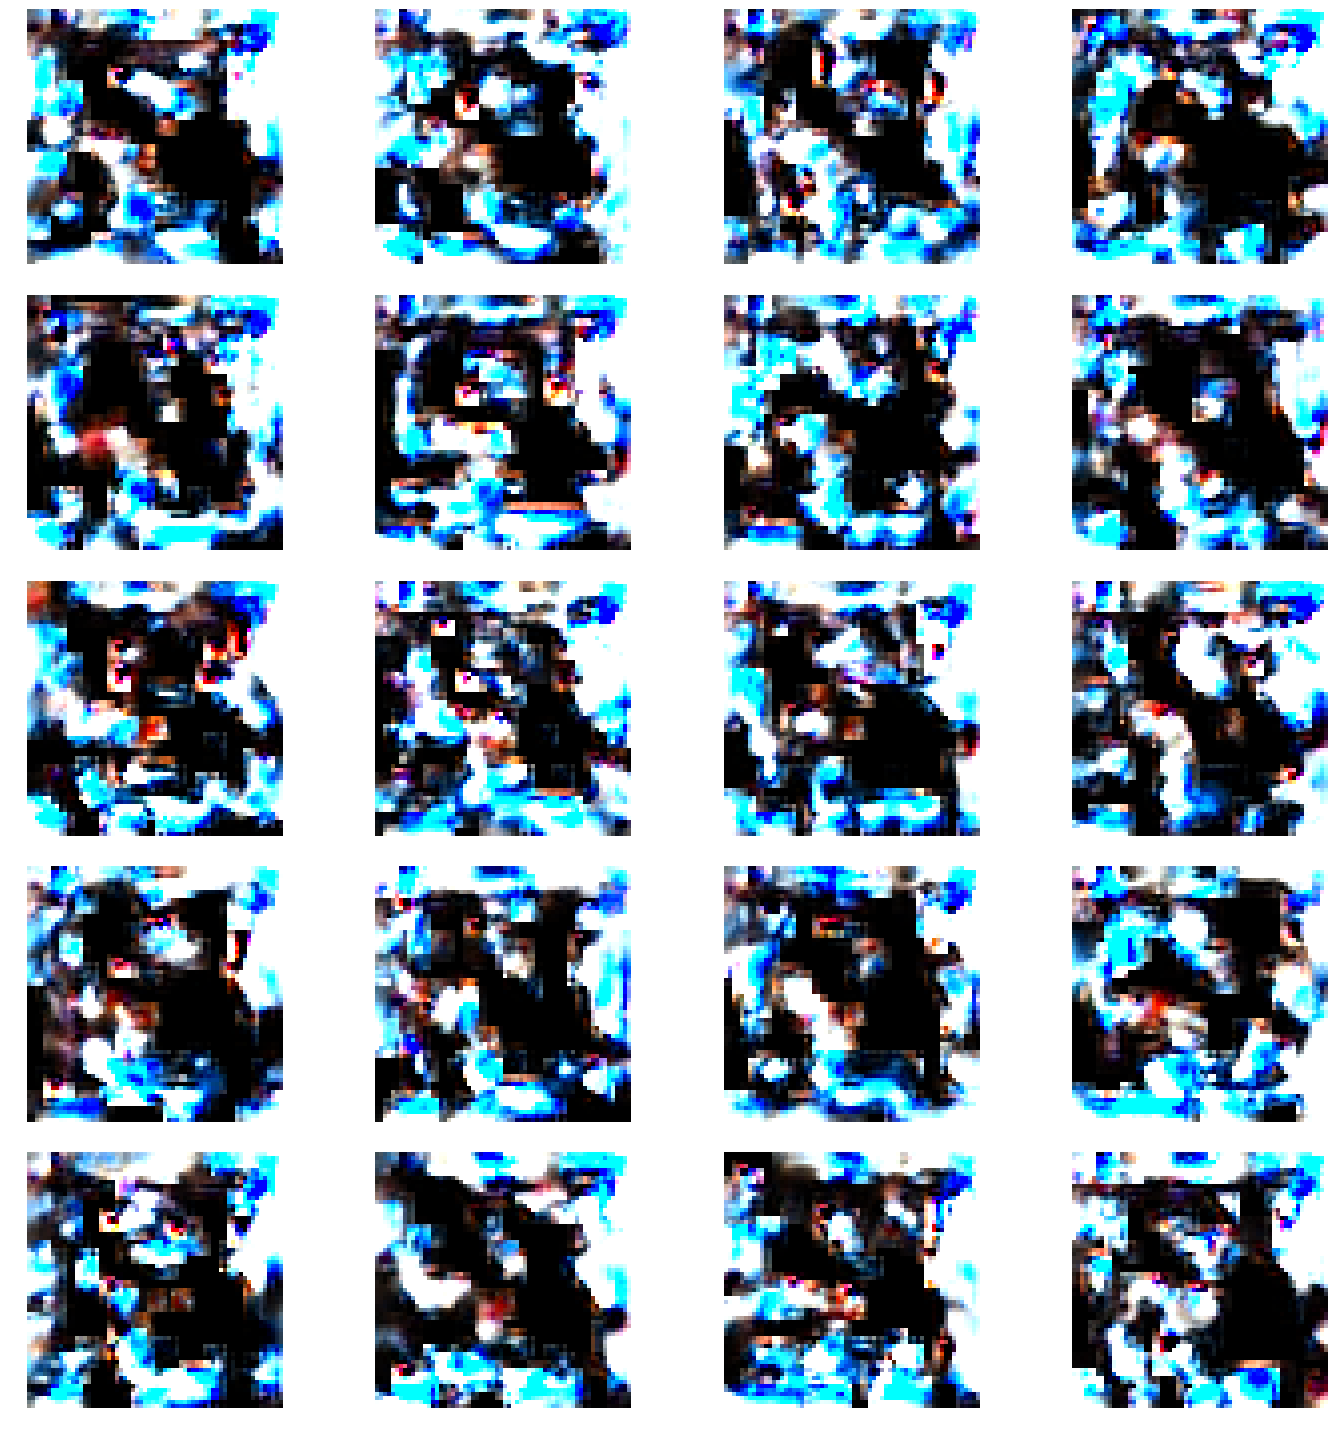

In [20]:
def create_images(figsize=(20,20),rows=(5,4)):
    images_amount = rows[0]*rows[1]
    random_input = np.random.rand(images_amount, 1152)
    preds = decoder.predict(random_input)
    
    plt.figure(figsize=figsize)

    i=0
    while i < images_amount:
        plt.subplot(rows[0],rows[1],i+1)
        plt.imshow(preds[i])
        plt.axis('off')
        i+=1

    plt.tight_layout()
    
create_images()

In [29]:
encoder.save("encoder.h5")
decoder.save("decoder.h5")
autoencoder.save("autoencoder.h5")